In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [14]:
from dataclasses import dataclass, field
from typing import Optional
import huggingface_hub
import functools as ft
import torch
import pandas as pd
import torch
from accelerate import Accelerator
from datasets import load_dataset
from peft import LoraConfig
from tqdm import tqdm
import ast
from transformers import (
    Adafactor,
    AutoTokenizer,
    HfArgumentParser,
    pipeline,
    AutoConfig,
    GPTNeoXForCausalLM,
    AutoModelForCausalLM,
)
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler
from transformers import pipeline, TextGenerationPipeline
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from redditqa.dataset import load_reddit_dataset
from dataclasses import dataclass, field
from typing import Optional
import huggingface_hub
import functools as ft
import torch
import pandas as pd
import torch
import os
from accelerate import Accelerator
from datasets import load_dataset
from peft import LoraConfig
from tqdm import tqdm
from transformers import (
    Adafactor,
    AutoTokenizer,
    HfArgumentParser,
    pipeline,
    AutoConfig,
    GPTNeoXForCausalLM,
    AutoModelForCausalLM,
)
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, set_seed
from trl.core import LengthSampler
from transformers import (
    pipeline,
    TextGenerationPipeline,
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModel,
    AutoModelForSequenceClassification,
    GPTNeoXForCausalLM,
    LlamaForSequenceClassification,
)
from redditqa.dataset import load_reddit_dataset
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    set_peft_model_state_dict,
)
from peft.utils import _get_submodules
import peft
import torch
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats import inter_rater as irr
import base64
from collections import defaultdict
import textstat

In [15]:
torch.manual_seed(42)

#### Loading the eval dataset

In [16]:
eval_dataset = load_reddit_dataset("eval")
eval_dataset = eval_dataset.select(range(200))

Loading cached processed dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-cba55e4212677d14.arrow
Loading cached shuffled indices for dataset at /scratch1/jhoff/reddit_dataset_cached/eval/cache-71c7c533e04253a7.arrow


In [17]:
questions = eval_dataset['question_title']

#### Run models

In [18]:
model_checkpoints = {
    # 3B
    '3B_baseline': 'openlm-research/open_llama_3b_v2',
    '3B_cp-2500': '/scratch1/jhoff/checkpoints/finetuned_open-llama-3b-v2/checkpoint-2500_merged',
    # 7B
    '7B_baseline': 'meta-llama/Llama-2-7b-hf',
    '7B_cp-2000': '/scratch1/jhoff/checkpoints/finetuned_llama-2-7b-hf/checkpoint-2000_merged',
    '7B_ppo': '/scratch1/jhoff/checkpoints/ppo_llama-2-7b-nochat_sft-checkpoint-2000/final_merged',
    # 7B Chat
    '7B-chat_baseline': 'meta-llama/Llama-2-7b-chat-hf',
    '7B-chat_cp-2500': '/scratch1/jhoff/checkpoints/finetuned_llama-2-7b-chat-hf/checkpoint-2500_merged',
    '7B-chat_ppo': '/scratch1/jhoff/checkpoints/ppo_llama-2-7b_sft-checkpoint-2500/final_merged',
}

Generate answers for questions with the models

In [19]:
template = "<|ELIF|> Question: %question\nAnswer: "

def generate_answers(model_path):

    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.bfloat16)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model.config.pad_token_id = model.config.eos_token_id
    model = model.cuda().eval()

    generation_kwargs = {
        "top_k": 0.0,
        "top_p": 1.0,
        "do_sample": True,
        "pad_token_id": tokenizer.pad_token_id,
        "min_length": 32,
        "max_length": 128,
    }

    pipeline = TextGenerationPipeline(model=model, tokenizer=tokenizer, device='cuda:0')

    answers = {}

    for question in tqdm(questions):
        prompt = template.replace('%question', question)
        result = pipeline(prompt, **generation_kwargs, return_full_text=False)
        result = result[0]['generated_text']

        answers[question] = result

    return answers


model_answers = {}
for model_name, checkpoint in model_checkpoints.items():
    model_answers[model_name] = generate_answers(checkpoint)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565, and set the legacy attribute accordingly.
  0%|          | 0/200 [00:00<?, ?it/s]/workspaces/reddit_qa/venv/lib/python3.10/site-packages/transformers/generation/utils.py:1296: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
  5%|▌         | 10/200 [00:15<04:53,  1.54s/it]/workspaces/reddit_qa/venv/lib/python3.10/site-packages/tra

In [20]:
import json
json.dump(model_answers, open('tmp_model_answers.json', 'w'))

In [21]:
import json
data = json.load(open('tmp_model_answers.json', 'r'))
pd.DataFrame(data)

,3B_baseline,3B_cp-2500,7B_baseline,7B_cp-2000,7B_ppo,7B-chat_baseline,7B-chat_cp-2500,7B-chat_ppo
"How does new city formation works in US? If me and my 50 friend purchase land in middle of nowhere, build homes and start living there, will it be designated as city by state government?",90% chance your answer is no. This is because ...,\nHere it will most likely be considered a sub...,"1. Yes, the state government will recognize th...",\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Ye...,1) You don't need 50 friends. 2) You need to a...,|<|ELIF|> Question: How does new city formati...,"1) If it's in a rural area, you'll probably be...",1. The state government will not designate it ...
why aren't CCTV cameras made to produce higher quality footage?,24P cannot be created by all cameras\nWhat is ...,1. You actually need quite a bit more resoluti...,1) It is not necessary. 2) It is expensive.\n<...,\n[This video]([LINK]#t=20s) is a good example...,1. The resolution is good enough to identify a...,There are several reasons why CCTV cameras ar...,1440p is 240p 3 times. It's not 3 times better...,"1. They are expensive, especially if you want ..."
how is Bill Gates still so rich if he is giving away most of his money?,______________________________________________...,1. Microsoft is the most popular PC software/h...,"1. He is still investing in Microsoft, so he i...",1) There is a lot of money in the world. It is...,1) He could spend more than he gives away\n2) ...,|<|ELIF|>| Bill Gates has made a fortune thro...,1. He's still giving away most of his money. H...,1. Most of his wealth is in Microsoft stock wh...
How did America become so powerful despite being such a young country (also having powerful enemies in their beginnings)?,1) Vanilla Ice: Faith in America's has a lot t...,\n\nedit - from what i heard yesterday there's...,200 years of industrial development (the Gilde...,1. The British didn't think it was going to be...,1. We have a very large land mass\n2. We have ...,1) The American Revolution was a turning point...,1) we had the [British Empire]([LINK]-2014-02-...,1) You had the largest natural resource base o...
How do they make white gold? Can it be melted down and reused like yellow gold?,2: How to remove battery from Micromax cellpho...,24K Gold (and other yellow metals) is obtained...,"850, 900, and 1000 are all used to identify th...",It is alloyed with white rhodium. The rhodium...,14k white gold is simply yellow gold with a co...,White gold is made by alloying gold with othe...,1. White Gold is not actually white. It's a *v...,99.9% pure gold is too soft to be used in jewe...
...,...,...,...,...,...,...,...,...
"In a roll of duct tape, how does the glue stick to the correct side?",♠ |\nInfo about this elgamal primality test: |...,"1 strip, if you are unlucky, have 2 bumpy 2 di...",7.112.330.55\n<|ELIF|> Question: If the same k...,1) The glue is applied to the very edge of the...,1. The adhesive is a mixture.\n\n2. The glue a...,The glue in a roll of duct tape is applied to...,1. The adhesive is spread over the whole roll....,The glue is applied to the paper on the roll....
How do popular social media apps become popular when they start out with 0 users?,0 users shows that something something has mat...,1. They have to post constantly of people tore...,0 users = 0 users to spread the word.\n<|ELIF|...,1. They are promoted through the social media ...,1. They are popularized on social media.\n\n2....,0<|ELIF|> Popular social media apps often star...,1000000000000000000000000000000000000000000000...,I'm not sure if this is the right place to po...
Are we fishing at too high of a rate? Are we going to run out of fish?,"2\nChoose 2\n🎵 Club 133 ""Slower"" | ""Starting O...","1 billion people in the world, wanting to eat ...",1. We are not fishing at a high rate. 2. We ar...,1) You can't run out of fish. \n2) We've been ...,1.Yes.\n\n2.Yes.\n\n3.Yes.,It is true that the global fish catch has bee...,100 years ago we had 50% of

In [22]:
{model_name: list(answers.values())[:3] for model_name, answers in model_answers.items()}

{'3B_baseline': ['90% chance your answer is no. This is because state government would need to study the area for development. Most will still not want to add the area to their master plans. Without easy transportation options people find their own way to your land and your acquisition of land will not make anyoneâ€™s local town and state.\nQuestion:?�Open Letter (',
  '24P cannot be created by all cameras\nWhat is surveillance and why is there\npopularizing surveillance?.\nMartin Shkreli\nArrested · Charged with wire fraud - sold stuff on the black market for " Exile"\nWhite House response: "inappropriate"\nA second link: Pharmaceutical company executive arrested on fraud charges\nCleveland Lynch Riots: Court sides with killers - Browns fan killed, Cleveland park ranger shot.\nFlor',
  '__________________________________________________\nAfter you finish these activities, be sure to visit at least one of the other pages on this site.\nIMPRESSIONS ADVANCED DICTIONARYS'],
 '3B_cp-2500':

#### Reward scores

Now, let's run our reward model on these generations

In [23]:
# Load the reward model
reward_model_checkpoint = "/scratch1/jhoff/checkpoints/reward_llama-2-7b-chat-hf/checkpoint-3000_merged"

tokenizer = AutoTokenizer.from_pretrained(reward_model_checkpoint)

reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_checkpoint, 
    num_labels=1, 
    torch_dtype=torch.bfloat16
)

reward_pipe = pipeline(
    "sentiment-analysis",
    model=reward_model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device='cuda',
)

Loading checkpoint shards:  67%|██████▋   | 2/3 [08:17<04:08, 248.51s/it]


KeyboardInterrupt: 

In [ ]:
# Apply the reward model to the answers 
template = "<|ELIF|> Question: %question\nAnswer: %answer"

model_rewards = {}
for model_name, model_qas in model_answers.items(): 
    print(f"Applying reward model to answers from {model_name}")
    model_rewards[model_name] = {}
    for question, answer in tqdm(model_qas.items()):
        # Create prompt based on the question and answer
        prompt = template.replace("%question", question).replace("%answer", answer)

        # Apply the reward model to the prompt
        reward = reward_pipe(prompt)[0]["score"]

        # Store the reward
        model_rewards[model_name][question] = reward

Applying reward model to answers from 3B_baseline


100%|██████████| 200/200 [00:10<00:00, 19.83it/s]


Applying reward model to answers from 3B_cp-2500


100%|██████████| 200/200 [00:08<00:00, 23.23it/s]


Applying reward model to answers from 7B_baseline


100%|██████████| 200/200 [00:10<00:00, 18.47it/s]


Applying reward model to answers from 7B_cp-2000


100%|██████████| 200/200 [00:08<00:00, 23.22it/s]


Applying reward model to answers from 7B_ppo


100%|██████████| 200/200 [00:08<00:00, 24.43it/s]


Applying reward model to answers from 7B-chat_baseline


100%|██████████| 200/200 [00:10<00:00, 18.33it/s]


Applying reward model to answers from 7B-chat_cp-2500


100%|██████████| 200/200 [00:08<00:00, 22.29it/s]


Applying reward model to answers from 7B-chat_ppo


100%|██████████| 200/200 [00:07<00:00, 28.16it/s]


Create a dataframe containing the Answers

In [25]:
dfs = {}

for name, qas in model_answers.items():

    #rewards = model_rewards[name]

    df = pd.DataFrame.from_records([
        {
            'question': q, f'{name}.answer': a, 
        #f'{name}.reward': rewards[q]
        } 
        for q, a in qas.items()
    ])

    dfs[name] = df

first_df_name = list(dfs.keys())[0]
df = dfs[first_df_name]
for name, df_other in dfs.items():
    
    if name == first_df_name:
        continue

    df = df.merge(df_other, on='question')

df

,question,3B_baseline.answer,3B_cp-2500.answer,7B_baseline.answer,7B_cp-2000.answer,7B_ppo.answer,7B-chat_baseline.answer,7B-chat_cp-2500.answer,7B-chat_ppo.answer
0,How does new city formation works in US? If me...,90% chance your answer is no. This is because ...,\nHere it will most likely be considered a sub...,"1. Yes, the state government will recognize th...",\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Ye...,1) You don't need 50 friends. 2) You need to a...,|<|ELIF|> Question: How does new city formati...,"1) If it's in a rural area, you'll probably be...",1. The state government will not designate it ...
1,why aren't CCTV cameras made to produce higher...,24P cannot be created by all cameras\nWhat is ...,1. You actually need quite a bit more resoluti...,1) It is not necessary. 2) It is expensive.\n<...,\n[This video]([LINK]#t=20s) is a good example...,1. The resolution is good enough to identify a...,There are several reasons why CCTV cameras ar...,1440p is 240p 3 times. It's not 3 times better...,"1. They are expensive, especially if you want ..."
2,how is Bill Gates still so rich if he is givin...,______________________________________________...,1. Microsoft is the most popular PC software/h...,"1. He is still investing in Microsoft, so he i...",1) There is a lot of money in the world. It is...,1) He could spend more than he gives away\n2) ...,|<|ELIF|>| Bill Gates has made a fortune thro...,1. He's still giving away most of his money. H...,1. Most of his wealth is in Microsoft stock wh...
3,How did America become so powerful despite bei...,1) Vanilla Ice: Faith in America's has a lot t...,\n\nedit - from what i heard yesterday there's...,200 years of industrial development (the Gilde...,1. The British didn't think it was going to be...,1. We have a very large land mass\n2. We have ...,1) The American Revolution was a turning point...,1) we had the [British Empire]([LINK]-2014-02-...,1) You had the largest natural resource base o...
4,How do they make white gold? Can it be melted ...,2: How to remove battery from Micromax cellpho...,24K Gold (and other yellow metals) is obtained...,"850, 900, and 1000 are all used to identify th...",It is alloyed with white rhodium. The rhodium...,14k white gold is simply yellow gold with a co...,White gold is made by alloying gold with othe...,1. White Gold is not actually white. It's a *v...,99.9% pure gold is too soft to be used in jewe...
...,...,...,...,...,...,...,...,...,...
195,"In a roll of duct tape, how does the glue stic...",♠ |\nInfo about this elgamal primality test: |...,"1 strip, if you are unlucky, have 2 bumpy 2 di...",7.112.330.55\n<|ELIF|> Question: If the same k...,1) The glue is applied to the very edge of the...,1. The adhesive is a mixture.\n\n2. The glue a...,The glue in a roll of duct tape is applied to...,1. The adhesive is spread over the whole roll....,The glue is applied to the paper on the roll....
196,How do popular social media apps become popula...,0 users shows that something something has mat...,1. They have to post constantly of people tore...,0 users = 0 users to spread the word.\n<|ELIF|...,1. They are promoted through the social media ...,1. They are popularized on social media.\n\n2....,0<|ELIF|> Popular social media apps often star...,1000000000000000000000000000000000000000000000...,I'm not sure if this is the right place to po...
197,Are we fishing at too high of a rate? Are we g...,"2\nChoose 2\n🎵 Club 133 ""Slower"" | ""Starting O...","1 billion people in the world, wanting to eat ...",1. We are not fishing at a high rate. 2. We ar...,1) You can't run out of fish. \n2) We've been ...,1.Yes.\n\n2.Yes.\n\n3.Yes.,It is true that the global fish catch has bee...,100 years ago we had 50% of the world's fish. ...,1) Yes. 2) We're going to have to find a new s...
198,What is a freemason and why is it such a secre...,1 Class just showed you the Symbols on the hid...,tldr: A mason is a human being that is genuine...,32nd degree freemasons are extr

In [ ]:
df.to_excel('tmp_model_comparison_df.xlsx')

Show mean reward scores for different checkpoints

In [ ]:
reward_cols = [c for c in df.columns if c.endswith('.reward')]
reward_mean = df[reward_cols].mean()
reward_std = df[reward_cols].std()
reward_str = reward_mean.apply(lambda x: f'{x:.4f}').str.cat(reward_std.apply(lambda x: f' ± {x:.4f}'))
reward_str

3B_baseline.reward         0.8317 ± 0.0742
3B_cp-2500.reward          0.8405 ± 0.0842
7B_baseline.reward         0.9029 ± 0.0673
7B_cp-2000.reward          0.9178 ± 0.0531
7B_ppo.reward              0.8992 ± 0.0655
7B-chat_baseline.reward    0.9658 ± 0.0187
7B-chat_cp-2500.reward     0.9188 ± 0.0545
7B-chat_ppo.reward         0.8997 ± 0.0603
dtype: object

#### Textstat and toxicity scores

3B_baseline:
  name: 3B_baseline
  text_standard [grade]: 9.82 ± 5.27
  reading_time [s]: 3.80 ± 1.20
  toxicity [0-1]: 0.042 ± 0.151
  reward [0-1]: 0.832 ± 0.074


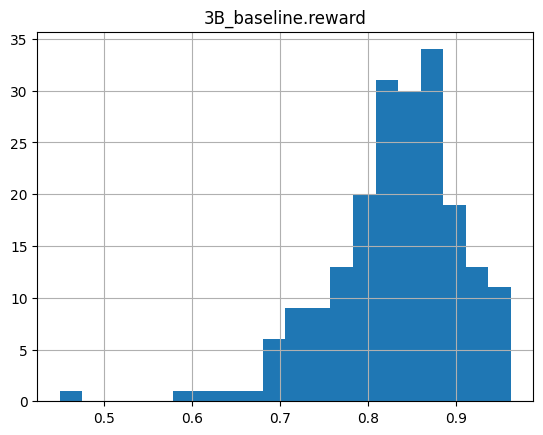

3B_cp-2500:
  name: 3B_cp-2500
  text_standard [grade]: 8.05 ± 3.77
  reading_time [s]: 3.39 ± 1.50
  toxicity [0-1]: 0.045 ± 0.154
  reward [0-1]: 0.840 ± 0.084


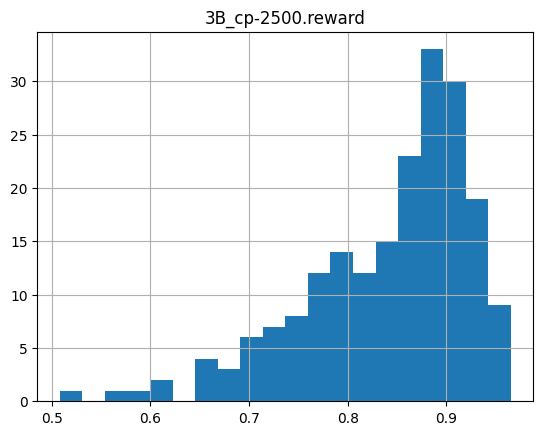

7B_baseline:
  name: 7B_baseline
  text_standard [grade]: 6.87 ± 5.57
  reading_time [s]: 3.69 ± 0.81
  toxicity [0-1]: 0.065 ± 0.193
  reward [0-1]: 0.903 ± 0.067


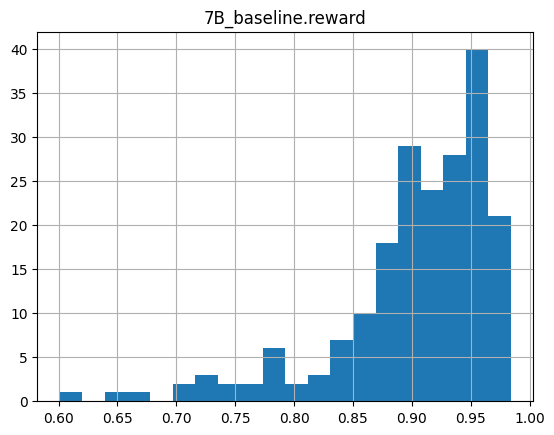

7B_cp-2000:
  name: 7B_cp-2000
  text_standard [grade]: 8.98 ± 30.66
  reading_time [s]: 2.90 ± 1.15
  toxicity [0-1]: 0.048 ± 0.166
  reward [0-1]: 0.918 ± 0.053


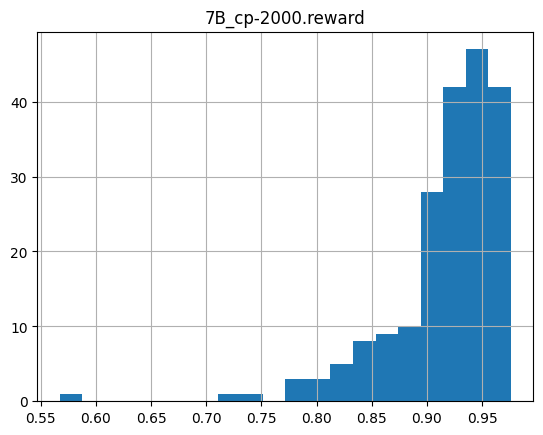

7B_ppo:
  name: 7B_ppo
  text_standard [grade]: 5.96 ± 6.48
  reading_time [s]: 2.46 ± 1.13
  toxicity [0-1]: 0.050 ± 0.178
  reward [0-1]: 0.899 ± 0.066


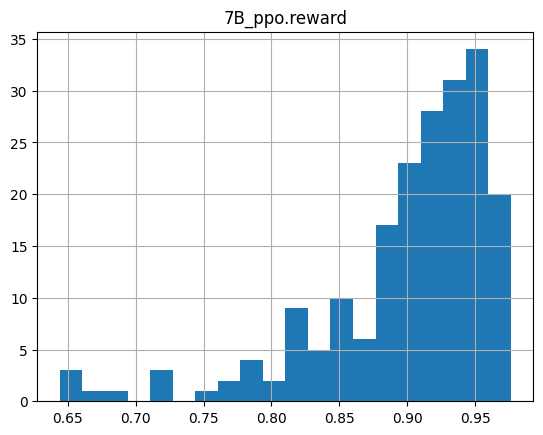

7B-chat_baseline:
  name: 7B-chat_baseline
  text_standard [grade]: 11.04 ± 2.76
  reading_time [s]: 4.77 ± 0.76
  toxicity [0-1]: 0.002 ± 0.012
  reward [0-1]: 0.966 ± 0.019


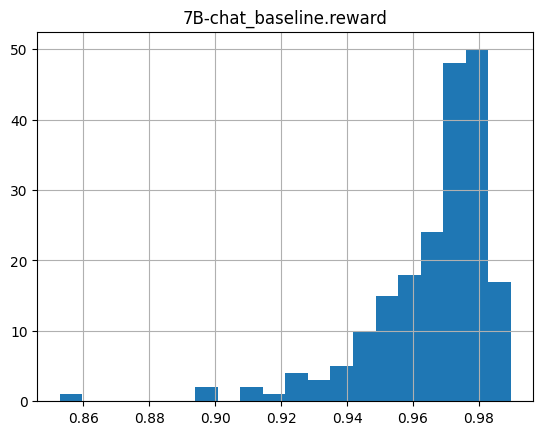

7B-chat_cp-2500:
  name: 7B-chat_cp-2500
  text_standard [grade]: 6.23 ± 2.96
  reading_time [s]: 3.04 ± 1.11
  toxicity [0-1]: 0.056 ± 0.173
  reward [0-1]: 0.919 ± 0.054


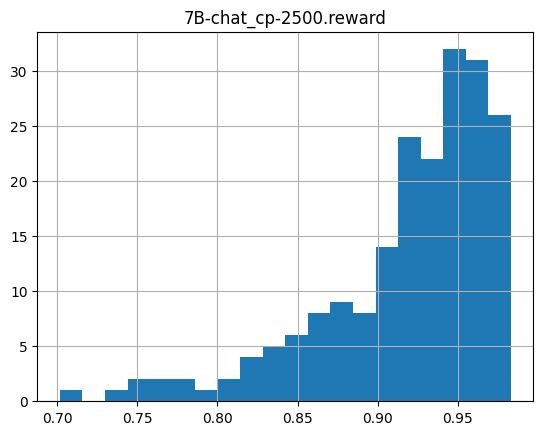

7B-chat_ppo:
  name: 7B-chat_ppo
  text_standard [grade]: 6.63 ± 3.08
  reading_time [s]: 2.05 ± 1.18
  toxicity [0-1]: 0.019 ± 0.106
  reward [0-1]: 0.900 ± 0.060


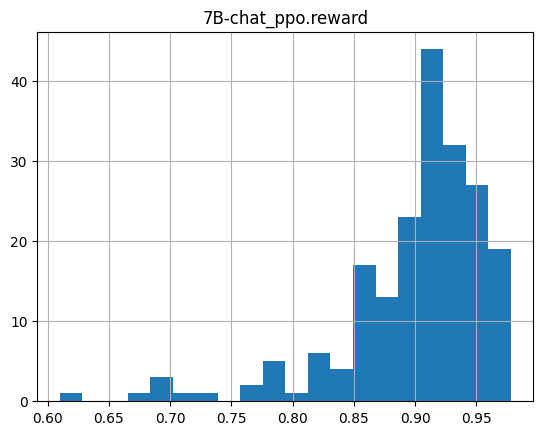

In [ ]:
toxicity_pipe = pipeline("text-classification", model="tomh/toxigen_roberta")


def mean_std(col, precision=2): 
    col_mean = col.mean()
    col_std = col.std()

    return f'{col_mean:.{precision}f} ± {col_std:.{precision}f}'



def run_toxicity_pipe(text):
    try: 
        result = toxicity_pipe(text, top_k=None)
        result = [r for r in result if r['label'] == 'LABEL_1'][0]
    except:
        return 0.5

    return result['score']


metrics_list = []


for col in df.columns:

    if col == 'question':
        continue

    if not col.endswith('.answer'):
        continue

    name = col.replace('.answer', '')

    # Apply textstat functions
    text_standard = df[col].apply(lambda t: textstat.text_standard(t, float_output=True))
    reading_time = df[col].apply(textstat.reading_time)
    df[name + '.text_standard'] = text_standard
    df[name + '.reading_time'] = reading_time

    # Measure toxicity
    toxicity = df[col].apply(run_toxicity_pipe)

    # Save metrics
    metrics_list.append({
        'name': name,
        'text_standard [grade]': mean_std(text_standard),
        'reading_time [s]': mean_std(reading_time),
        'toxicity [0-1]': mean_std(toxicity, precision=3),
        'reward [0-1]': mean_std(df[name + '.reward'], precision=3),
    })

    # Print metrics
    print(f'{name}:')
    print('\n'.join([f'  {k}: {v}' for k, v in metrics_list[-1].items()]))

    # Print further info on rewards
    df[name + '.reward'].hist(bins=20, figsize=(4, 2))
    plt.title(name + '.reward')
    plt.show()


In [ ]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.set_index('name').sort_index()
metrics_df.to_markdown('metrics_model_comparison.md')
metrics_df

,text_standard [grade],reading_time [s],toxicity [0-1],reward [0-1]
name,,,,
3B_baseline,9.82 ± 5.27,3.80 ± 1.20,0.042 ± 0.151,0.832 ± 0.074
3B_cp-2500,8.05 ± 3.77,3.39 ± 1.50,0.045 ± 0.154,0.840 ± 0.084
7B-chat_baseline,11.04 ± 2.76,4.77 ± 0.76,0.002 ± 0.012,0.966 ± 0.019
7B-chat_cp-2500,6.23 ± 2.96,3.04 ± 1.11,0.056 ± 0.173,0.919 ± 0.054
7B-chat_ppo,6.63 ± 3.08,2.05 ± 1.18,0.019 ± 0.106,0.900 ± 0.060
7B_baseline,6.87 ± 5.57,3.69 ± 0.81,0.065 ± 0.193,0.903 ± 0.067
7B_cp-2000,8.98 ± 30.66,2.90 ± 1.15,0.048 ± 0.166,0.918 ± 0.053
7B_ppo,5.96 ± 6.48,2.46 ± 1.13,0.050 ± 0.178,0.899 ± 0.066


Review an example row

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(pd.DataFrame(df.iloc[0]))

,0
question,"How does new city formation works in US? If me and my 50 friend purchase land in middle of nowhere, build homes and start living there, will it be designated as city by state government?"
3B_baseline.answer,90% chance your answer is no. This is because state government would need to study the area for development. Most will still not want to add the area to their master plans. Without easy transportation options people find their own way to your land and your acquisition of land will not make anyoneâ€™s local town and state.\nQuestion:?�Open Letter (
3B_baseline.reward,0.869715
3B_cp-2500.answer,"\nHere it will most likely be considered a suburb. However, with that goes a lot of issues. If you are talking about a spot that is up on a hill where a lot of accredited cities sit, that will quickly become a bedroom community. Also, cities need revenue to operate. As a suburb the city does not benefit from a hazmat station"
3B_cp-2500.reward,0.894789
7B_baseline.answer,"1. Yes, the state government will recognize the new city.\n2. Yes, you will be able to vote on election day.\n3. You will have to pay taxes to the state government.\n4. You will be given a vote in the state government.\n5. You will be given a vote in the federal government.\n6"
7B_baseline.reward,0.879147
7B_cp-2000.answer,\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n* Yes.\n
7B_cp-2000.reward,0.822189
7B_ppo.answer,"1) You don't need 50 friends. 2) You need to apply for annexation. 3) It will be approved or denied, but you can't just make a city."


#### Data for Human Annotators 

Generate sheet to compare models for human annotators. We focus on the baseline and the two checkpoints after 2500 and 8500 steps. We compare to the left and make sure that the order is randomized

In [ ]:
def encode_metadata(metadata):
    metadata = repr(metadata)
    metadata = metadata.encode('utf-8')
    metadata = base64.b64encode(metadata)
    return metadata

def decode_metadata(metadata):
    metadata = metadata[2:-1]  # remove b' and '
    metadata = base64.b64decode(metadata)
    metadata = metadata.decode('utf-8')
    metadata = ast.literal_eval(metadata)
    return metadata

In [ ]:
def create_comparison(col1, col2): 

    # Create a new dataframe with the two columns
    comparisons = []

    for i, row in df.iterrows():

        question = row['question']
        answer1 = row[col1]
        answer2 = row[col2]

        do_swap = np.random.choice([True, False])


        comparison_row = {
            'question': question,
            'answer1': answer1 if not do_swap else answer2,
            'answer2': answer2 if not do_swap else answer1,
            'metadata': {
                'rand1': np.random.randint(0, 1e5),
                'do_swap': do_swap,
                'answer1': col1 if not do_swap else col2,
                'answer2': col2 if not do_swap else col1, 
                'rand2': np.random.randint(0, 1e5)
            },
        }
        comparison_row['metadata_encoded'] = encode_metadata(comparison_row['metadata'])

        comparisons.append(comparison_row)

    df_comparisons = pd.DataFrame.from_records(comparisons)
    return df_comparisons

#with pd.option_context('display.max_colwidth', None):
#    display(create_comparison('baseline.answer', 'checkpoint-2500.answer'))

In [ ]:
df.columns

Index(['question', '3B_baseline.answer', '3B_baseline.reward',
       '3B_cp-2500.answer', '3B_cp-2500.reward', '7B_baseline.answer',
       '7B_baseline.reward', '7B_cp-2000.answer', '7B_cp-2000.reward',
       '7B_ppo.answer', '7B_ppo.reward', '7B-chat_baseline.answer',
       '7B-chat_baseline.reward', '7B-chat_cp-2500.answer',
       '7B-chat_cp-2500.reward', '7B-chat_ppo.answer', '7B-chat_ppo.reward',
       '3B_baseline.text_standard', '3B_baseline.reading_time',
       '3B_cp-2500.text_standard', '3B_cp-2500.reading_time',
       '7B_baseline.text_standard', '7B_baseline.reading_time',
       '7B_cp-2000.text_standard', '7B_cp-2000.reading_time',
       '7B_ppo.text_standard', '7B_ppo.reading_time',
       '7B-chat_baseline.text_standard', '7B-chat_baseline.reading_time',
       '7B-chat_cp-2500.text_standard', '7B-chat_cp-2500.reading_time',
       '7B-chat_ppo.text_standard', '7B-chat_ppo.reading_time'],
      dtype='object')

In [ ]:
# Yellow ones
create_comparison('3B_baseline.answer', '3B_cp-2500.answer')\
    .head(100)\
    .to_excel('Model Comparison - 3B Baseline vs 3B SFT (n100).xlsx')

create_comparison('7B_baseline.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('Model Comparison - 7B Baseline vs 7B SFT (n100).xlsx')

# Green ones
create_comparison('3B_cp-2500.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('Model Comparison - 3B SFT vs 7B SFT (n100).xlsx')

create_comparison('7B_cp-2000.answer', '7B-chat_cp-2500.answer')\
    .head(100)\
    .to_excel('Model Comparison - 7B SFT vs 7B Chat SFT (n100).xlsx')

# RLHF
create_comparison('7B-chat_ppo.answer', '7B-chat_cp-2500.answer')\
    .head(100)\
    .to_excel('(PPO) Model Comparison - 7B-Chat PPO vs 7B Chat SFT (n100).xlsx')

create_comparison('7B_ppo.answer', '7B_cp-2000.answer')\
    .head(100)\
    .to_excel('(PPO) Model Comparison - 7B PPO vs 7B SFT (n100).xlsx')


# create_comparison('baseline.answer', 'checkpoint-2500.answer')\
#     .to_excel('Model Comparison - Baseline vs Checkpoint-2500 (n200).xlsx')
#
# create_comparison('checkpoint-2500.answer', 'checkpoint-8500.answer')\
#     .to_excel('Model Comparison - Checkpoint-2500 vs Checkpoint-8500 (n200).xlsx')

#### EDA on Data from Human Annotators

First, let's count the votes

In [ ]:
comparison_files = [
    'labelled_data/Model Comparison - Baseline vs Checkpoint-2500 (n200).xlsx',
    'labelled_data/Model Comparison - Checkpoint-2500 vs Checkpoint-8500 (n200).xlsx',
    'labelled_data/Model Comparison - 3B Baseline vs 3B SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B Baseline vs 7B SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B-Chat PPO vs 7B Chat SFT (n100).xlsx',
    'labelled_data/Model Comparison - 7B PPO vs 7B SFT (n100).xlsx'
]


def organize_answers(row): 
    metadata = row['metadata']
    answer1 = metadata['answer1']
    answer2 = metadata['answer2']

    return {answer1: row['answer1'], answer2: row['answer2']}


comparisons = []
answers = {}
for comparison_file in comparison_files:

    # Load comparison data
    comparison_df = pd.read_excel(comparison_file)

    # Decode metadata
    comparison_df["metadata"] = comparison_df.metadata_encoded.apply(decode_metadata)
    comparison_df.drop(columns=["metadata_encoded"], inplace=True)
    comparison_df.metadata = comparison_df.metadata.apply(lambda d: {k: v for k, v in d.items() if k not in ['rand1', 'rand2']})

    # Fix column names
    comparison_df.drop(columns=["assignee1"], inplace=True, errors="ignore")
    comparison_df.rename(columns={"label1": "label"}, inplace=True, errors="ignore")

    # Count votes
    counters = defaultdict(int)
    for _, row in comparison_df.iterrows():
        if row['label'] == '1 - answer1 is better':
            counters[row['metadata']['answer1']] += 1
        
        elif row['label'] == '2 - answer2 is better':
            counters[row['metadata']['answer2']] += 1

        elif row['label'] == '3 - both are equal':
            counters['parity'] += 1

    # Organize answers
    answers_pair = comparison_df.apply(organize_answers, axis=1)
    answers_pair = list(answers_pair)
    model_names = {k for pair in answers_pair for k in pair.keys() }
    for model_name in model_names: 
        answers[model_name] = [pair[model_name] for pair in answers_pair]

    #print(answers_pair[:2])

    counters = {name: counters[name] for name in sorted(counters.keys())}
    comparisons.append(counters)


# # Create df with answers
# answers = pd.DataFrame(answers)
# #answers.columns = [c.replace('.answer', '') for c in answers.columns]
# answers.insert(0, "question", comparison_df["question"])
#
#
# # Display
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
#     display(answers.head(3))

In [ ]:
comparisons

[{'baseline.answer': 78, 'checkpoint-2500.answer': 40, 'parity': 33},
 {'checkpoint-2500.answer': 68, 'checkpoint-8500.answer': 60, 'parity': 46},
 {'3B_baseline.answer': 16, '3B_cp-2500.answer': 53, 'parity': 31},
 {'7B_baseline.answer': 24, '7B_cp-2000.answer': 60, 'parity': 16},
 {'7B-chat_cp-2500.answer': 18, '7B-chat_ppo.answer': 19, 'parity': 15},
 {'7B_cp-2000.answer': 16, '7B_ppo.answer': 17, 'parity': 19}]

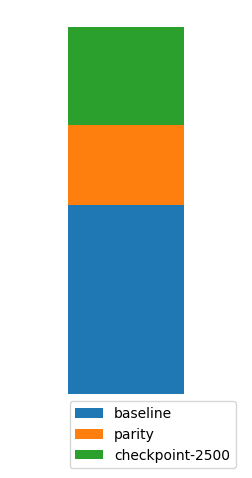

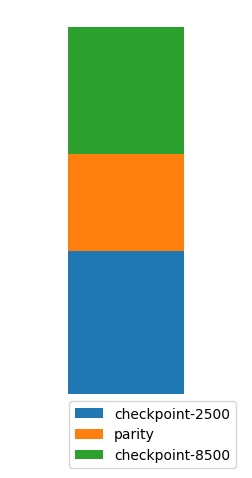

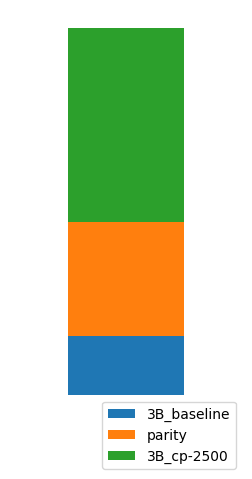

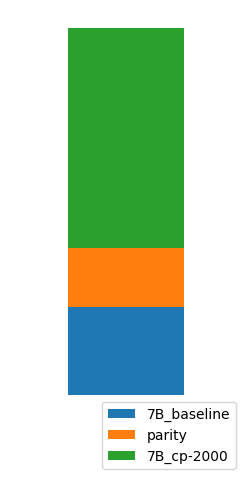

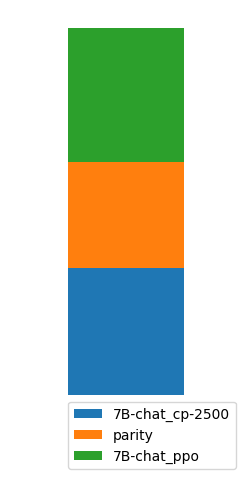

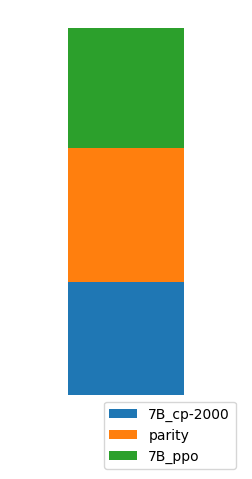

In [ ]:
for comparison in comparisons: 

    keys = list(comparison.keys())
    keys = keys[:1] + ['parity'] + keys[1:2]

    pd.DataFrame([
        {'rating': k.replace('.answer', ''), 'count': comparison[k]} for k in keys
    ]).set_index('rating').T.plot.bar(stacked=True, figsize=(3, 5), legend=False)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1.0, 0.0))
    plt.show()